In [102]:
import numpy as np
import tensorly as tl
from copy import deepcopy

In [137]:
mse = lambda a, b: ((a - b)**2).mean()

In [106]:
k = 2
dim = 20

# Create symmetric T with random vectors
#w = np.random.uniform(size=k)
w = np.ones(k)
w /= w.sum()
v1 = np.random.normal(size=(dim)) + 1
v2 = np.random.normal(size=(dim)) + 2
vs = np.stack([v1, v2])

# Compute the weighted outer product 
T = np.einsum('i,ij,ik,il->jkl', w, vs, vs, vs)
print(T.shape)

(20, 20, 20)


In [118]:
vs.shape

(2, 20)

In [141]:


# Decomposition
weights, factors = tl.decomposition.parafac_power_iteration(T, rank=2)

T_hat_cp = tl.cp_tensor.CPTensor((weights, factors))
T_hat_cp_norm = tl.cp_tensor.cp_normalize(T_hat_cp)

weights = T_hat_cp_norm.weights


print(f'reconstructed weights:\t{np.sort(weights / weights.sum())}')
print(f'original weights:\t{np.sort(w)}')



T_hat = tl.cp_to_tensor(T_hat_cp_norm)
mse(T, T_hat)




reconstructed weights:	[0.12020578 0.87979422]
original weights:	[0.5 0.5]


0.24604792354240623

In [142]:
# Reconstruct matrix

print(T_hat_cp_norm)
print(f'{len(T_hat_cp_norm.factors)} factors')
print(f'{len(T_hat_cp_norm.weights)} weights')

T_recover = np.einsum('i,ji,ki,li->jkl', T_hat_cp_norm.weights, *T_hat_cp_norm.factors)

mse(T_recover, T_hat)

(weights, factors) : rank-2 CPTensor of shape (20, 20, 20) 
3 factors
2 weights


3.0540896864087613e-31

In [62]:
# Power iteration

weights, factors = tl.decomposition.parafac_power_iteration(T, rank=k)

print(f'reconstructed weights:\t{np.sort(weights) / weights.sum()}')
print(f'original weights:\t{np.sort(w)}')

reconstructed weights:	[0.01225734 0.98774266]
original weights:	[0.34335817 0.65664183]


In [72]:
tensor = tl.random.random_cp(shape=(10, 10, 10), rank=2)
tensor

(weights, factors) : rank-2 CPTensor of shape (10, 10, 10) 

In [289]:
import itertools
import time

k = 2
dim = 10

# Create symmetric T with random vectors
#w = np.random.uniform(size=k)
#w = np.ones(k)
#w /= w.sum()
w = np.array([0.3, 0.7])

v1 = np.random.normal(size=(dim)) + 1
v2 = np.random.normal(size=(dim)) + 2
vs = np.stack([v1, v2])

print(vs.shape)

# Compute the weighted outer product 
M3 = np.einsum('i,ij,ik,il->jkl', w, vs, vs, vs)
print(M3.shape)


M2 = np.einsum('i,ij,ik->jk', w, vs, vs)
M2.shape


past = time.time()
factors, weights = tensor_decomp(M2, M3, k)
print(time.time() - past)

factors = factors.T


#T_hat = np.einsum('i,ij,ik,il->jkl', weights, factors, factors, factors)
#mse(T_hat, M3)



mse(factors, vs)



(2, 10)
(10, 10, 10)
0.33769893646240234


4.59295773137468e-31

In [290]:
factors

array([[ 3.33012752, -0.80693294,  2.63727743,  1.11684768,  0.3530164 ,
         3.32308719,  1.71748133,  2.71546469, -1.03396881,  0.60140421],
       [ 2.65525247,  1.47335257,  1.7260274 ,  2.20489611,  0.69630458,
        -0.39943447,  2.22551685,  2.38814121,  2.85751867,  2.40172808]])

In [331]:
def multimap(A, V_array):
    """Compute a tensor product as a multilinear map.(pg. 2778, Section 2)

        Parameters
        ----------
        A
            A multidimensional tensor
        V_array
            Array of vectors to compute tensor against

    """
    p = len(V_array)
    for i in range(len(V_array)):
        if len(V_array[i].shape) == 1:
            V_array[i] = np.expand_dims(V_array[i], axis=1)

    n = V_array[0].shape[0]
    dims = [a.shape[1] for a in V_array]
    dim_ranges = [range(a.shape[1]) for a in V_array]
    B = np.zeros(dims)

    all_indices = list(itertools.product(*dim_ranges)) #i_1,...,i_p
    all_vectors = list(itertools.product(range(n), repeat=p)) #j_1,...,j_p

    for ind in all_indices:
        for vec in all_vectors:
            tmp = A[vec]
            for k in range(p):
                tmp *= V_array[k][vec[k], ind[k]]
            B[ind] += tmp
    return B

def two_tensor_prod(w, x, y):
    """
    A type of outer product
    """
    r = x.shape[0]
    M2 = np.zeros([r, r])

    for a in range(w.shape[0]):
        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                M2[i,j] += w[a] * x[i,a] * y[j,a]

    return M2

def three_tensor_prod(w, x, y, z):
    """
    Three-way outer product
    """
    r = x.shape[0]
    M3 = np.zeros([r, r, r])

    if len(w.shape) == 0:
        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                for k in range(z.shape[0]):
                    M3[i,j,k] += w * x[i] * y[j] * z[k]
    else:
        for a in range(w.shape[0]):
            for i in range(x.shape[0]):
                for j in range(y.shape[0]):
                    for k in range(z.shape[0]):
                        M3[i,j,k] += w[a] * x[i,a] * y[j,a] * z[k,a]

    return M3

def T_map(T, u):
    """ Power method base transformation (pg. 2790, equation (5))

        Parameters
        ----------
        T
            A multidimensional tensor
        u
            A candidate eigenvector

        Returns
        -------
        t   
            Transformed candidate

    """

    d = u.shape[0]
    t = np.zeros(d)
    for i in range(d):
        for j in range(d):
            for k in range(d):
                t[i] += T[i,j,k] * u[j] * u[k]
    return t

def tensor_decomp(M2, M3, comps):
    """ Tensor Decomposition Algorithm (pg. 2795, Algorithm 1)
        This is combined with reduction (4.3.1)

        Parameters
        ----------
        M2
            Symmetric matrix to aid the decomposition
        M3
            Symmetric tensor to be decomposed
        comps
            Number of eigencomponents to return

        Returns
        -------
        mu_rec   
            Recovered eigenvectors (a matrix with #comps eigenvectors)
        lam_rec
            Recovered eigenvalues (a vector with #comps eigenvalues)            

    """
    lam_rec = np.zeros(comps)
    mu_rec = np.zeros((M2.shape[0], comps))

    for b in range(comps):
        # initial eigendecomposition used in reduction (4.3.1)
        lam, v = np.linalg.eigh(M2)
        idx = lam.argsort()[::-1]
        lam = lam[idx]
        v = v[:, idx]

        # keep only the positive eigenvalues
        n_eigpos = np.sum(lam > 10e-10)
        if n_eigpos > 0:
            W = v[:,:n_eigpos] @ np.diag(1.0/np.sqrt(np.abs(lam[:n_eigpos])))

            B = np.linalg.pinv(W.T)
            M3_tilde = multimap(M3, [W, W, W]) # reduction complete

            # decomposition setup
            # TODO try different hps if this doesn't work
            N        = 1000               # number of power iterations
            restarts = 10                 # number of random restarts # NOTE critical
            tau_star = 0                  # best robust eigenvalue so far
            u_star   = np.zeros(n_eigpos) # best eigenvector so far

            # repeated restarts to find best eigenvector
            for j in range(restarts):
                # randomly draw from unit sphere (step 2)
                u = np.random.rand(n_eigpos)
                u /= np.linalg.norm(u)

                # power iteration for N iterations
                for i in range(N):
                    u = T_map(M3_tilde, u)
                    u /= np.linalg.norm(u)

                # check for best eigenvalue
                if j == 0 or (j > 0 and multimap(M3_tilde, [u, u, u]) > tau_star):
                    tau_star = multimap(M3_tilde, [u, u, u])
                    u_star = u

            # N more power iterations for best eigenvector found
            u = u_star
            for i in range(N):
                u = T_map(M3_tilde, u)
                u /= np.linalg.norm(u)

            # recovered modified (post-reduction) eigenvalue
            lamb = (T_map(M3_tilde, u) / u)[0]

            # recover original eigenvector and eigenvalue pair
            mu_rec[:, b] = lamb* B @ u
            lam_rec[b] = 1/lamb**2

            # deflation: remove component, repeat
            M2 -= lam_rec[b] * np.outer(mu_rec[:,b], mu_rec[:,b])
            M3 -= three_tensor_prod(np.array(lam_rec[b]), mu_rec[:,b], mu_rec[:,b], mu_rec[:,b])

    return mu_rec, lam_rec


def tensor_decomp_x3(w, x1, x2, x3, debug=False, return_errs=False):
    k = w.shape[0]
    dim = x1.shape[0]
    x_tilde_1 = np.zeros((dim, k))
    ex32 = np.einsum('i,ji,ki->jk', w, x3, x2)
    ex12 = np.einsum('i,ji,ki->jk', w, x1, x2)
    ex12_inv = np.linalg.pinv(ex12)
    ex31 = np.einsum('i,ji,ki->jk', w, x3, x1)
    ex21 = np.einsum('i,ji,ki->jk', w, x2, x1)
    ex21_inv = np.linalg.pinv(ex21)
    x_tilde_1 = (ex32 @ ex12_inv) @ x1
    x_tilde_2 = (ex31 @ ex21_inv) @ x2
    M2 = np.einsum('i,ji,ki->jk', w, x_tilde_1, x_tilde_2)
    M3 = np.einsum('i,ji,ki,li->jkl', w, x_tilde_1, x_tilde_2, x3)
    factors, weights = tensor_decomp(M2, M3, k)
    if debug:
        print(f'error:', mse(factors, x3))
    if return_errs:
        return weights, x3, mse(factors, x3)
    return weights, x3

def tensor_decomp_full(w, x1, x2, x3, debug=False, return_errs=False):
    w, x3_rec, err_3_12 = tensor_decomp_x3(w, x1, x2, x3, debug=debug, return_errs=True)
    w, x3_rec, err_3_21 = tensor_decomp_x3(w, x2, x1, x3, debug=debug, return_errs=True)
    err_3 = np.min([err_3_12, err_3_21])

    w, x2_rec, err_2_13 = tensor_decomp_x3(w, x1, x3, x2, debug=debug, return_errs=True)
    w, x2_rec, err_2_31 = tensor_decomp_x3(w, x3, x1, x2, debug=debug, return_errs=True)
    err_2 = np.min([err_2_13, err_2_31])

    w, x1_rec, err_1_23 = tensor_decomp_x3(w, x2, x3, x1, debug=debug, return_errs=True)
    w, x1_rec, err_1_32 = tensor_decomp_x3(w, x3, x2, x1, debug=debug, return_errs=True)
    err_1 = np.min([err_1_23, err_1_32])
    
    if return_errs:
        return w, x1_rec, x2_rec, x3_rec, np.array([err_1, err_2, err_3])
    return w, x1_rec, x2_rec, x3_rec







In [338]:
errs_res = []
dim = 10
eps = 0.1
for p in np.arange(0, 1.0+eps, eps):
    w = np.array([p, 1.0 - p])
    k = len(w)
    x1 = np.random.normal(size=(dim, k)) + 1
    x2 = np.random.normal(size=(dim, k)) + 2
    x3 = np.random.normal(size=(dim, k)) + 3

    w_rec, x1_rec, x2_rec, x3_rec, errs = tensor_decomp_full(
        w, x1, x2, x3, debug=False, return_errs=True)

    print(np.sort(w_rec)[0], np.sort(w)[0])

    errs_res.append(errs)

0.0 0.0
0.0999999999999995 0.1
0.20000000000000054 0.2
0.299999999999997 0.30000000000000004
0.4000000000000001 0.4
0.4999999999999942 0.5
0.39999999999999697 0.3999999999999999
0.29999999999999777 0.29999999999999993
0.20000000000000348 0.19999999999999996
0.10000000000000017 0.09999999999999998
0.0 0.0


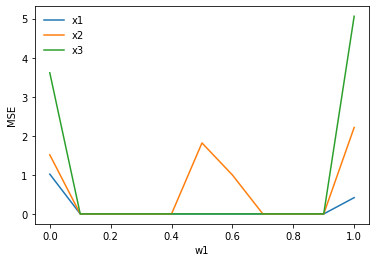

In [339]:
import matplotlib.pyplot as plt

errs_res = np.array(errs_res)
xticks = np.arange(0, 1.0+eps, eps)

plt.plot(xticks, errs_res[:, 0], label='x1')
plt.plot(xticks, errs_res[:, 1], label='x2')
plt.plot(xticks, errs_res[:, 2], label='x3')
plt.legend(frameon=False)
plt.xlabel('w1')
plt.ylabel('MSE')

plt.show()